# Notebook for Parts of Speech Analysis

Using spaCy for parts of speech analysis, we want to create relative frequency tables for the parts of speech by year.

Currently processes the "Fakespeak-ENG modified.xlsx" file (I've renamed my copy to "Fakespeak_ENG_modified.xlsx" to create a more consistent path), but will eventually be run on data from MisInfoText as well.

From the original data file, we use the following columns: ID, combinedLabel, originalTextType, originalBodyText, originalDateYear

We are processing text from the "originalBodyText" column.

In [1]:
import spacy
import pandas as pd

In [ ]:
!pip install xlsxwriter # for writing to multiple excel sheets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading articles into dataframes, separated by year

In [2]:
# input = '/content/drive/My Drive/fake_news_over_time/Fakespeak_ENG_modified.xlsx'
input = "./data/Fakespeak-ENG/Fakespeak-ENG modified.xlsx"

In [3]:
fakespeak_df = pd.read_excel(input, sheet_name="Working", usecols=['ID', 'combinedLabel', 'originalTextType', 'originalBodyText', 'originalDateYear'])

In [4]:
fakespeak_df.head()

,ID,combinedLabel,originalTextType,originalBodyText,originalDateYear
0,Politifact_FALSE_Social media_687276,False,Social media,Mexico is paying for the Wall through the new ...,2019
1,Politifact_FALSE_Social media_25111,False,Social media,"Chuck Schumer: ""why should American citizens b...",2019
2,Politifact_FALSE_Social media_735424,False,Social media,Billions of dollars are sent to the State of C...,2019
3,Politifact_FALSE_Social media_594307,False,Social media,If 50 Billion $$ were set aside to go towards ...,2019
4,Politifact_FALSE_Social media_839325,False,Social media,Huge@#CD 9 news. \n@ncsbe\n sent letter to eve...,2019


## Tagging parts of speech using spaCy

Using the small English web model, we tag the parts of speech in the body text by making article's body text a string, analyzing the string using spaCy, and then appending each token to a list manually.

We end up with a dataframe of many rows since each tag/tagged token takes up one row - this is fine since we are looking at overall counts in a year and we don't need to preserve the delineation between articles.

In [5]:
# create the spacy model
nlp = spacy.load("en_core_web_sm")

# lists to hold spacy output elements
tokens = []
pos = []
years = []

for index, row in fakespeak_df.iterrows():
  doc = nlp(row['originalBodyText'])
  year = row['originalDateYear']

  for token in doc:
    tokens.append(token.text)
    pos.append(token.pos_)
    years.append(year)

At this point, we are testing the code with just articles from 2019, so pos_df holds the tokens and tags for 2019 articles specifically as shown below.

In [6]:
# dictionary to map the lists
tags = {
    'Token': tokens,
    'POS': pos,
    'Year': years
}

# create a new dataframe containing the pos
pos_df = pd.DataFrame(tags)

In [7]:
pos_df.head()

,Token,POS,Year
0,Mexico,PROPN,2019
1,is,AUX,2019
2,paying,VERB,2019
3,for,ADP,2019
4,the,DET,2019


## Create relative frequency tables of parts of speech by year

In [8]:
# do this for 2019 to start
pos_2019_df = pos_df[pos_df['Year'] == 2019]

counts_19 = pos_2019_df['POS'].value_counts()
total_19 = counts_19.sum()

print(counts_19)
print("Total number of tokens: ", total_19)

POS
NOUN     6652
VERB     4175
PUNCT    4112
ADP      3549
PROPN    3481
DET      2705
PRON     2501
ADJ      2217
AUX      1920
ADV      1229
CCONJ    1089
PART     1033
SPACE    1020
NUM       745
SCONJ     679
SYM       137
INTJ       56
X          52
Name: count, dtype: int64
Total number of tokens:  37352


<Axes: xlabel='POS'>

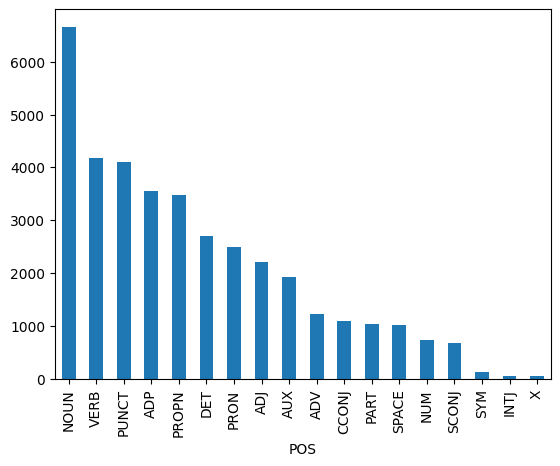

In [9]:
counts_19.plot(kind='bar')

Now that we have tested to find that the tagging and counting works for 2019, repeat the process for the remaining years. Since we are creating new dataframes per year, this is a bit messy (the alterative was to write a helper function that did all this in a for loop, but since we need to create the dataframe variables manually anyway it's currently trivial to copy/paste the code for the five years).

In [10]:
# find the counts for the remaining years
pos_2020_df = pos_df[pos_df['Year'] == 2020]
counts_20 = pos_2020_df['POS'].value_counts()
total_20 = counts_20.sum()

pos_2021_df = pos_df[pos_df['Year'] == 2021]
counts_21 = pos_2021_df['POS'].value_counts()
total_21 = counts_21.sum()

pos_2022_df = pos_df[pos_df['Year'] == 2022]
counts_22 = pos_2022_df['POS'].value_counts()
total_22 = counts_22.sum()

pos_2023_df = pos_df[pos_df['Year'] == 2023]
counts_23 = pos_2023_df['POS'].value_counts()
total_23 = counts_23.sum()

pos_2024_df = pos_df[pos_df['Year'] == 2024]
counts_24 = pos_2024_df['POS'].value_counts()
total_24 = counts_24.sum()

Note that when doing the counts, we're not looking a proportion across total number of words, we are looking at proportion across total number of **tags** (which include punctuation, spaces, etc.)

The proportion is given by a decimal number, calculated by taking `count_of_tag / total_tag_count` for each tag per year. To get the percentage, multiply all values by 100.

In [11]:
# read these counts into their respective dataframes
counts_19_df = counts_19.rename_axis('POS').reset_index(name='counts')
counts_19_df['proportion'] = counts_19_df['counts'] / total_19

counts_20_df = counts_20.rename_axis('POS').reset_index(name='counts')
counts_20_df['proportion'] = counts_20_df['counts'] / total_20

counts_21_df = counts_21.rename_axis('POS').reset_index(name='counts')
counts_21_df['proportion'] = counts_21_df['counts'] / total_21

counts_22_df = counts_22.rename_axis('POS').reset_index(name='counts')
counts_22_df['proportion'] = counts_22_df['counts'] / total_22

counts_23_df = counts_23.rename_axis('POS').reset_index(name='counts')
counts_23_df['proportion'] = counts_23_df['counts'] / total_23

counts_24_df = counts_24.rename_axis('POS').reset_index(name='counts')
counts_24_df['proportion'] = counts_24_df['counts'] / total_24

In [12]:
counts_19_df.head()

,POS,counts,proportion
0,NOUN,6652,0.178090
1,VERB,4175,0.111774
2,PUNCT,4112,0.110088
3,ADP,3549,0.095015
4,PROPN,3481,0.093194


## Making summary tables
This more easily compares the numbers across the years. Create two summary dataframes: one to compare absolute counts, the other to compare proportions. The row labels are the years, the column labels are the parts of speech tags in alphabetical order, taken from [this documentation](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/13-POS-Keywords.html).

In [13]:
# helper function to produce a row of all the tag counts from a year
# where df is the count_xx_df produced in the previous section
def summarize_counts(df):
  tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
          'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']

  count = []

  for tag in tags:
    if tag in df['POS'].values:
      count.append(df.loc[df['POS'] == tag, 'counts'].item())

    else:
      count.append(0)

  return count


# helper function to produce a row of all the tag proportions from a year
def summarize_prop(df):
  tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
          'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']

  prop = []

  for tag in tags:
    if tag in df['POS'].values:
      prop.append(df.loc[df['POS'] == tag, 'proportion'].item())

    else:
      prop.append(0)

  return prop

In [14]:
# create summary dataframes
counts_summary = []
prop_summary = []

counts_summary.append(summarize_counts(counts_19_df))
counts_summary.append(summarize_counts(counts_20_df))
counts_summary.append(summarize_counts(counts_21_df))
counts_summary.append(summarize_counts(counts_22_df))
counts_summary.append(summarize_counts(counts_23_df))
counts_summary.append(summarize_counts(counts_24_df))

prop_summary.append(summarize_prop(counts_19_df))
prop_summary.append(summarize_prop(counts_20_df))
prop_summary.append(summarize_prop(counts_21_df))
prop_summary.append(summarize_prop(counts_22_df))
prop_summary.append(summarize_prop(counts_23_df))
prop_summary.append(summarize_prop(counts_24_df))

# create dataframes
counts_summary_df = pd.DataFrame(counts_summary)
prop_summary_df = pd.DataFrame(prop_summary)

# row and column headers
row_labels = ['2019', '2020', '2021', '2022', '2023', '2024']
col_labels = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
          'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']

counts_summary_df.index = row_labels
counts_summary_df.columns = col_labels

prop_summary_df.index = row_labels
prop_summary_df.columns = col_labels

In [15]:
counts_summary_df.head()

,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,SPACE
2019,2217,3549,1229,1920,0,1089,2705,56,6652,745,1033,2501,3481,4112,679,137,4175,52,1020
2020,7873,12647,4701,7384,0,3514,10204,159,23150,3127,3476,8755,15319,15741,2654,677,14871,246,4237
2021,8908,14244,5104,7567,0,4081,11508,145,26880,3505,3903,8791,14260,17555,2749,525,16371,174,4261
2022,5521,8714,3256,4389,0,2395,6823,78,16507,2473,2228,5218,8568,10649,1694,637,9667,171,2585
2023,7131,11261,3681,5563,0,3136,9150,80,22107,2129,2886,6500,11914,13934,2106,749,12996,189,3906


In [16]:
prop_summary_df.head()

,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,SPACE
2019,0.059354,0.095015,0.032903,0.051403,0,0.029155,0.072419,0.001499,0.178090,0.019945,0.027656,0.066958,0.093194,0.110088,0.018178,0.003668,0.111774,0.001392,0.027308
2020,0.056748,0.091159,0.033885,0.053224,0,0.025329,0.073550,0.001146,0.166865,0.022539,0.025055,0.063106,0.110419,0.113461,0.019130,0.004880,0.107190,0.001773,0.030540
2021,0.059177,0.094625,0.033907,0.050269,0,0.027111,0.076449,0.000963,0.178568,0.023284,0.025928,0.058400,0.094731,0.116620,0.018262,0.003488,0.108755,0.001156,0.028306
2022,0.060291,0.095159,0.035556,0.047929,0,0.026154,0.074509,0.000852,0.180261,0.027006,0.024330,0.056982,0.093565,0.116290,0.018499,0.006956,0.105566,0.001867,0.028229
2023,0.059715,0.094299,0.030824,0.046584,0,0.026261,0.076622,0.000670,0.185123,0.017828,0.024167,0.054431,0.099767,0.116683,0.017636,0.006272,0.108828,0.001583,0.032709


## Writing dataframes to excel spreadsheet

In [ ]:
output = '/content/drive/My Drive/fake_news_over_time/POS_frequency.xlsx'

Output is a single excel spreadsheet with the counts/proportion of tags of each year in separate tabs, and then two summary tabs at the end to compare across years.

In [ ]:
# create excel writer object to initialize new workbook
writer = pd.ExcelWriter(output, engine="xlsxwriter")

# write dataframes to different worksheets
counts_19_df.to_excel(writer, sheet_name="2019", index=False)
counts_20_df.to_excel(writer, sheet_name="2020", index=False)
counts_21_df.to_excel(writer, sheet_name="2021", index=False)
counts_22_df.to_excel(writer, sheet_name="2022", index=False)
counts_23_df.to_excel(writer, sheet_name="2023", index=False)
counts_24_df.to_excel(writer, sheet_name="2024", index=False)

counts_summary_df.to_excel(writer, sheet_name="counts_summary")
prop_summary_df.to_excel(writer, sheet_name="prop_summary")

# close the excel writer and output file
writer.close()